# IV. Popularity Classification

To adress the imbalance of popularity, we can convert them in a classification problem, as follows.

From the shape of the popularity distribution, we can classify the popularity as:

- **Low Popularity**: Scores from 0 to 20 – This captures the large number of songs with very low popularity scores.
- **Medium Popularity**: Scores from 21 to 50 – This captures the body of the distribution where most of the songs lie.
- **High Popularity**: Scores above 50 – This captures the tail end of the distribution, which has songs with higher popularity.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('cleaneddata.pkl')

### Creating new classes from the popularity score: 

In [3]:
def popularity_classification(score):
    if score <= 20:
        return 'Low Popularity'
    elif score <= 50:
        return 'Medium Popularity'
    else:
        return 'High Popularity'

df['popularity_class'] = df['popularity'].apply(popularity_classification)

### Checking for class imbalance:

In [4]:
popularity_counts = df['popularity_class'].value_counts()
print(popularity_counts)

popularity_class
Medium Popularity    51971
Low Popularity       33829
High Popularity      27749
Name: count, dtype: int64


In [5]:
popularity_percentage = df['popularity_class'].value_counts(normalize=True) * 100
print(popularity_percentage)

popularity_class
Medium Popularity    45.769668
Low Popularity       29.792424
High Popularity      24.437908
Name: proportion, dtype: float64


### Insights from above: 
We see there's a class imbalance with medium popularity (21-50) containing 45.7% of our data. Low and high popularity having 29.7% and 24.4% respectively. 

## Additional EDA:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113549 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        113549 non-null  int64  
 1   duration_ms       113549 non-null  int64  
 2   danceability      113549 non-null  float64
 3   energy            113549 non-null  float64
 4   loudness          113549 non-null  float64
 5   speechiness       113549 non-null  float64
 6   acousticness      113549 non-null  float64
 7   instrumentalness  113549 non-null  float64
 8   liveness          113549 non-null  float64
 9   valence           113549 non-null  float64
 10  tempo             113549 non-null  float64
 11  key_sin           113549 non-null  float64
 12  key_cos           113549 non-null  float64
 13  mode_1            113549 non-null  int32  
 14  time_signature_1  113549 non-null  int32  
 15  time_signature_3  113549 non-null  int32  
 16  time_signature_4  113549 

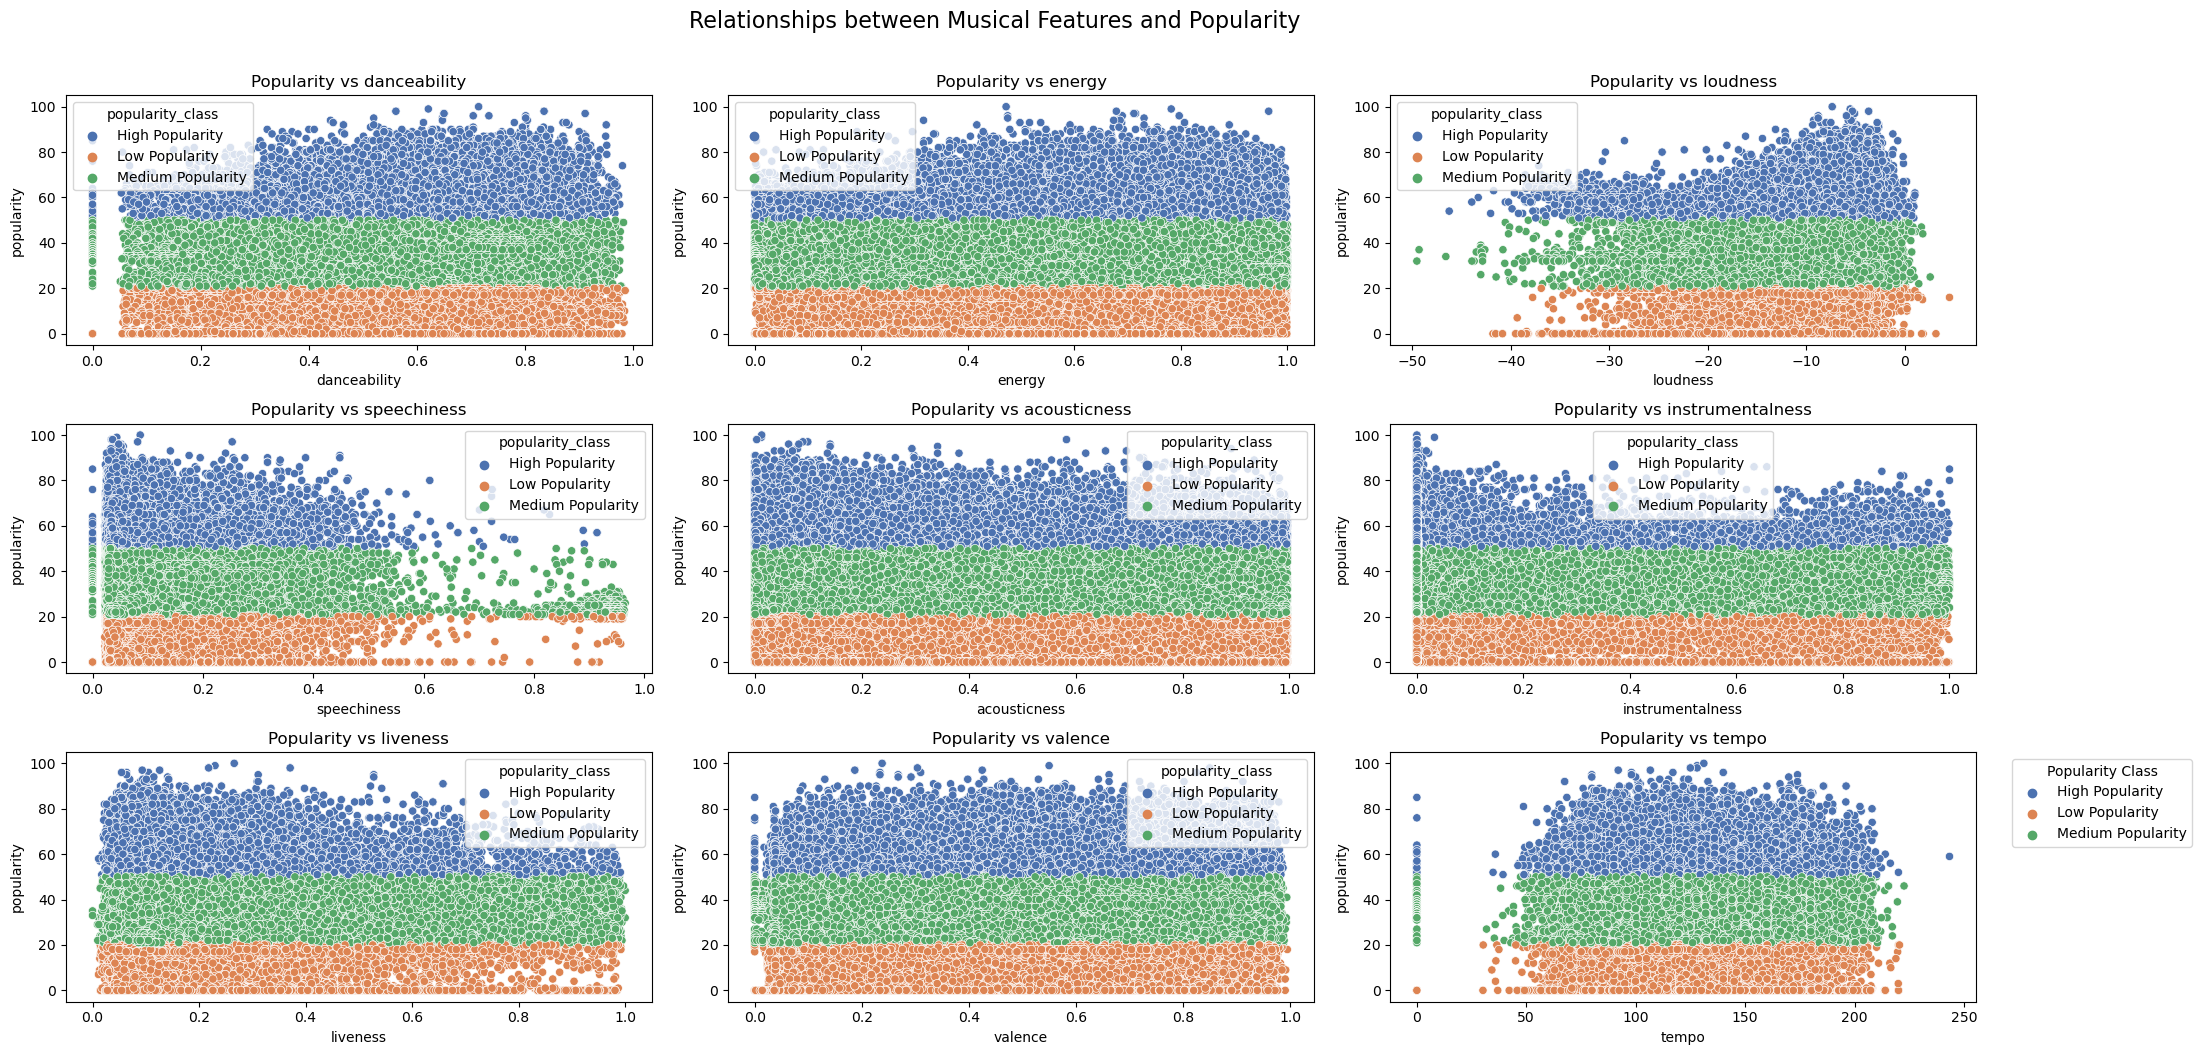

In [7]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=feature, y='popularity', data=df, hue='popularity_class', palette='deep', legend='full')
    plt.title(f'Popularity vs {feature}')
plt.tight_layout()
plt.suptitle('Relationships between Musical Features and Popularity', y=1.05, fontsize=16)
plt.legend(title='Popularity Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Model Building Approach: 

Since our target variable - popularity_class exibits class imbalance, to make this more balanced, I'll be using two approaches here and comparing the results: 

1. Using __Oversampling with SMOTE (Synthetic Minority Over-sampling Technique):__
    - In oversampling, we aim to increase the representation of the minority classes by adding more similar data points. Rather than simply duplicating existing rows, which can lead to overfitting, Hence, I will be using SMOTE.
    - SMOTE generates synthetic samples from the minority class by interpolating between existing data. The advantage of using SMOTE in a dataset of size 110k+ is that it gives the dataset with new examples without losing any information, which is good to get a generalized model.

2. Using __Undersampling__:
    - In undersampling, we reduce the size of the overrepresented classes by eliminating data points. This direct approach aims to balance the class distribution by reducing the majority class to a level similar to the minority class.
    - This method can lead to a significant loss of data but it might be advantageous for computational efficiency and speed, especially with a larger dataset like ours. 
    
From the above, it seems that the Oversampling with SMOTE approach is more viable but considering as to how our models performed in the regression problem, it's a safe approach considering both the methods and comparing the models across the accuracy, precision, recall and f1_score.

### Encoding target variable:

_Encoding target variable `popularity_class` with 0, 1 and 2 - Label Encoding (as `popularity_class` is an ordinal categorical variable)._

In [8]:
#Label encoding manually (As SkLearn inbuilt label encoder was taking the highest count of class as 2, which is incorrect)
popularity_mapping = {
    'Low Popularity': 0,  
    'Medium Popularity': 1,  
    'High Popularity': 2 
}

df['popularity_class_encoded'] = df['popularity_class'].map(popularity_mapping)

In [9]:
#Deleting the popularity_class
del df['popularity_class']

### Checking for multicollinearity:

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Calculating the scores
df_with_const = add_constant(df.drop(['popularity'], axis=1))
vif_data = pd.DataFrame()
vif_data["Feature"] = df_with_const.columns[1:]  
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(1, df_with_const.shape[1])]
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data_sorted)

                     Feature        VIF
15          time_signature_4  69.935718
14          time_signature_3  54.886582
16          time_signature_5  12.375340
13          time_signature_1   7.114991
2                     energy   4.274489
3                   loudness   3.275333
5               acousticness   2.442383
8                    valence   1.597067
1               danceability   1.589665
6           instrumentalness   1.487404
4                speechiness   1.256142
7                   liveness   1.145532
17                  explicit   1.144541
9                      tempo   1.117907
0                duration_ms   1.060930
18  popularity_class_encoded   1.027414
12                    mode_1   1.025683
10                   key_sin   1.008404
11                   key_cos   1.005996


Deleting time_signature_4 (as similarly done for the regression problem to remove multicollinearity).

In [11]:
del df['time_signature_4']

In [12]:
#Calculating again
df_with_const = add_constant(df.drop(['popularity'], axis=1))
vif_data = pd.DataFrame()
vif_data["Feature"] = df_with_const.columns[1:]  
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(1, df_with_const.shape[1])]
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data_sorted)

                     Feature       VIF
2                     energy  4.263996
3                   loudness  3.273075
5               acousticness  2.427104
8                    valence  1.595969
1               danceability  1.567053
6           instrumentalness  1.486794
4                speechiness  1.256133
16                  explicit  1.144471
7                   liveness  1.143047
14          time_signature_3  1.124170
9                      tempo  1.094284
0                duration_ms  1.059736
15          time_signature_5  1.040332
17  popularity_class_encoded  1.027333
12                    mode_1  1.025656
13          time_signature_1  1.020952
10                   key_sin  1.008279
11                   key_cos  1.005833


Since VIF of all feature is < 5, we have successfully avoided multicollinearity. 

In [13]:
#Deleting the actual popularity score
del df['popularity']

## Model Building (using Oversampling):

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time

In [15]:
#Target and Feature split
X = df.drop(['popularity_class_encoded'], axis=1)
y = df['popularity_class_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Applying SMOTE to the training data
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Models for evaluation (the true, false -> tells us if data has to be scaled or not)
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000), True),
    ("KNN", KNeighborsClassifier(), True),
    ("Decision Tree", DecisionTreeClassifier(), False),
    ("Random Forest", RandomForestClassifier(), False),
    ("AdaBoost", AdaBoostClassifier(), False),
    ("Naive Bayes", GaussianNB(), True),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), False)
]

In [55]:
#Checking to see if SMOTE has been applied
#First, checking the pre-SMOTE shape
X_train.shape

(79484, 17)

In [56]:
#Checking the shape of the dataframe after SMOTE
X_train_smote.shape

(108837, 17)

From above, we see that there's an increase in the number of rows indicating that new synthetic data has been generated. 

In [16]:
results_list = []

#Dictionary to store each model
fitted_models = {}

#Scaling features if necessary
if any(model[2] for model in models):  #Checking if any model requires scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_smote)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled, X_test_scaled = X_train_smote, X_test

In [17]:
#Training and evaluating models
for name, model, needs_scaling in models:
    start_time = time.time()
    
    #Fitting the model
    model.fit(X_train_scaled if needs_scaling else X_train_smote, y_train_smote)
    
    #Storing the fitted model
    fitted_models[name] = model
    
    #Making predictions
    y_pred_train = model.predict(X_train_scaled if needs_scaling else X_train_smote)
    y_pred_test = model.predict(X_test_scaled if needs_scaling else X_test)
    
    #Evaluating performance
    train_accuracy = accuracy_score(y_train_smote, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
    time_taken = time.time() - start_time
    
    #Appending results to the list
    results_list.append({"Model": name, "Accuracy_Train": train_accuracy, 
                         "Accuracy_Test": test_accuracy, "Precision": precision,
                         "Recall": recall, "F1_Score": f1, "Time_Taken": time_taken})

results_df = pd.DataFrame(results_list)

In [18]:
results_df

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F1_Score,Time_Taken
0,Logistic Regression,0.438316,0.413093,0.438859,0.413093,0.417133,0.394175
1,KNN,0.745629,0.553882,0.562171,0.553882,0.554417,48.060850
2,Decision Tree,0.993219,0.620021,0.626779,0.620021,0.621220,4.997102
3,Random Forest,0.993219,0.698723,0.699100,0.698723,0.696967,98.118424
4,AdaBoost,0.481334,0.432350,0.433261,0.432350,0.432762,13.856373
5,Naive Bayes,0.410210,0.347659,0.439555,0.347659,0.324030,0.152189
6,XGBoost,0.718441,0.594804,0.590078,0.594804,0.589560,3.870808


## Insights from above: 
- __Random Forest__: Highest test accuracy (69.8%), excellent precision, recall and balanced F1 score.
- __XGBoost__: Test accuracy (59.4%) can be further improved but here we see that this model is very efficient (3.87 seconds). 

Will be using these two models to further tune them (using randomizedsearchCV) since these two models seem promising, as it can potentially increase accuracy and can help get a generalised model. __The reason I didn't tune decision tree despite having a better accuracy (3% more) in comparision to XGBoost is because, DT is overfitting here with Training Accuracy of 99%. While, XGBoost on the other hand has a training accuracy of 71%, which tells us that XGBoost is a better generalised model.__ Hence, I will be performing hyper-parameter tuning for Random Forest and XGBoost. 

## Hyper-parameter tuning for Random Forest and XGBoost

In [19]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [20]:
#Hyper-parameter Tuning and Evaluation Function with Time Measurement
def tune_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, n_iter=10, cv=5):
    start_time = time.time()
    
    #Performing RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter, cv=cv, verbose=2, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    end_time = time.time()
    
    #Our Best Model
    best_model = random_search.best_estimator_
    
    #Predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    #Evaluation
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
    
    #Compilation of Results
    results = {
        'Model': best_model.__class__.__name__,
        'Best Parameters': random_search.best_params_,
        'Accuracy Train': train_accuracy,
        'Accuracy Test': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Time Taken (s)': end_time - start_time
    }
    return results, best_model

In [21]:
#Parameters for rf and xgb
xgb_params = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [5, 7, 9],
    'colsample_bytree': [0.7, 1, 1.3],
    'subsample': [0.6, 0.8, 1]
}

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [0.5, 1, 1.5]
}

In [22]:
#Tuning XGBoost and capturing both results and the best model
xgb_tuning_results, xgb_best_model = tune_and_evaluate(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    xgb_params,
    X_train_smote,
    y_train_smote,
    X_test,
    y_test
)

#Tuning Random Forest and capturing both results and the best model
rf_tuning_results, rf_best_model = tune_and_evaluate(
    RandomForestClassifier(),
    rf_params,
    X_train_smote,
    y_train_smote,
    X_test,
    y_test
)

#Preparing the results for display
results_data = [xgb_tuning_results, rf_tuning_results]
results_df = pd.DataFrame(results_data)

#Displaying the tuning results
results_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Model,Best Parameters,Accuracy Train,Accuracy Test,Precision,Recall,F1 Score,Time Taken (s)
0,XGBClassifier,"{'subsample': 0.6, 'n_estimators': 1500, 'max_...",0.992016,0.702246,0.702752,0.702246,0.699914,1313.261948
1,RandomForestClassifier,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.993219,0.704800,0.706132,0.704800,0.702660,1192.952474


In [24]:
#To check the full parameters
pd.set_option('display.max_colwidth', None)
results_df

,Model,Best Parameters,Accuracy Train,Accuracy Test,Precision,Recall,F1 Score,Time Taken (s)
0,XGBClassifier,"{'subsample': 0.6, 'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}",0.992016,0.702246,0.702752,0.702246,0.699914,1313.261948
1,RandomForestClassifier,"{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}",0.993219,0.704800,0.706132,0.704800,0.702660,1192.952474


### Insights from above:
 - After performing hyper-parameter tuning we see that Random Forest has a test accuracy of 70.48%, which is an increase of 0.6% in comparision to pre-hyperparameter RF, but on the cost of efficiency (from 101s to 1192s).
- After performing hyper-parameter tuning for XGBoost, there's a significant increase in accuracy value from 59% to 70.2%. But again here at the cost of time, there's a significant decrease in efficiency from 3.8s to 1313s, which is acceptable since the tuning helped increase 10%+.
- Both the above models are overfitting, for ranfom forest it was previously overfitting too (before the hyper-parameter tuning) but for XGBoost it went from a low scoring generalized model to match the best model accuracy but with overfit. 
- From the best parameters we can notice that XGBoost has room for improvement, hence narrowing/focusing the parameters for XGBoost and running again. 

### Narrowing down the parameters for XGBoost and running again:

In [57]:
xgb_params_adjusted = {
    'n_estimators': [1400, 1500, 1600],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [8, 9, 10],
    'colsample_bytree': [0.65, 0.7, 0.75],
    'subsample': [0.55, 0.6, 0.65]
}

xgb_tuning_results_adjusted, xgb_best_model_adjusted = tune_and_evaluate(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    xgb_params_adjusted,
    X_train_smote,
    y_train_smote,
    X_test,
    y_test
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [58]:
#Appending the results
results_data.append(xgb_tuning_results_adjusted)
results_df = pd.DataFrame(results_data)

In [59]:
pd.set_option('display.max_colwidth', None)
results_df

,Model,Best Parameters,Accuracy Train,Accuracy Test,Precision,Recall,F1 Score,Time Taken (s)
0,XGBClassifier,"{'subsample': 0.6, 'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}",0.992016,0.702246,0.702752,0.702246,0.699914,1313.261948
1,RandomForestClassifier,"{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}",0.993219,0.704800,0.706132,0.704800,0.702660,1192.952474
2,XGBClassifier,"{'subsample': 0.65, 'n_estimators': 1600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.75}",0.992300,0.705005,0.706087,0.705005,0.702697,4100.917325


### Insights from above: 
After further tuning XGBoost, we see an increase of 0.3% in test accuracy but the evaluation time of the model quadrupled. 

# Final Model Evaluation: 

After training and evaluating several models, we've compared their performances based on various metrics. Below is the summary of the top performing models:

| Rank | Model                     | Best Parameters                                                                                                   | Accuracy (Train) | Accuracy (Test) | Precision | Recall  | F1 Score | Time Taken (s) |
|------|---------------------------|-------------------------------------------------------------------------------------------------------------------|------------------|-----------------|-----------|--------|----------|----------------|
| 1    | RandomForestClassifier    | {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}                          | 0.9932           | 0.7048          | 0.7061    | 0.7048  | 0.7027   | 1192.95        |
| 2    | XGBClassifier (Model 2)   | {'subsample': 0.65, 'n_estimators': 1600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.75}      | 0.9923           | 0.7050          | 0.7061    | 0.7050  | 0.7027   | 4100.92        |
| 3    | XGBClassifier (Model 1)   | {'subsample': 0.6, 'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}          | 0.9920           | 0.7022          | 0.7028    | 0.7022  | 0.6999   | 1313.26        |

- The **RandomForestClassifier** and **XGBClassifier (Model 2)** are very closely matched in terms of test accuracy, precision, and F1 score. However, RandomForestClassifier is slightly better in terms of test accuracy and has a significantly shorter training time, making it the preferred model for this dataset.
- Although XGBClassifier (Model 1) has the shortest training time among the top models, its performance metrics are slightly lower than the others.
- Given the balance between performance and training time, **RandomForestClassifier** is chosen as the final model for this task.

## Feature Importance of Random Forest:

In [28]:
#Getting feature importances from the Random Forest model
feature_importances = rf_best_model.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

,Feature,Importance
0,duration_ms,0.096132
5,acousticness,0.091778
8,valence,0.091401
1,danceability,0.090219
7,liveness,0.089911
9,tempo,0.086000
4,speechiness,0.085979
2,energy,0.085768
3,loudness,0.084943
6,instrumentalness,0.078105


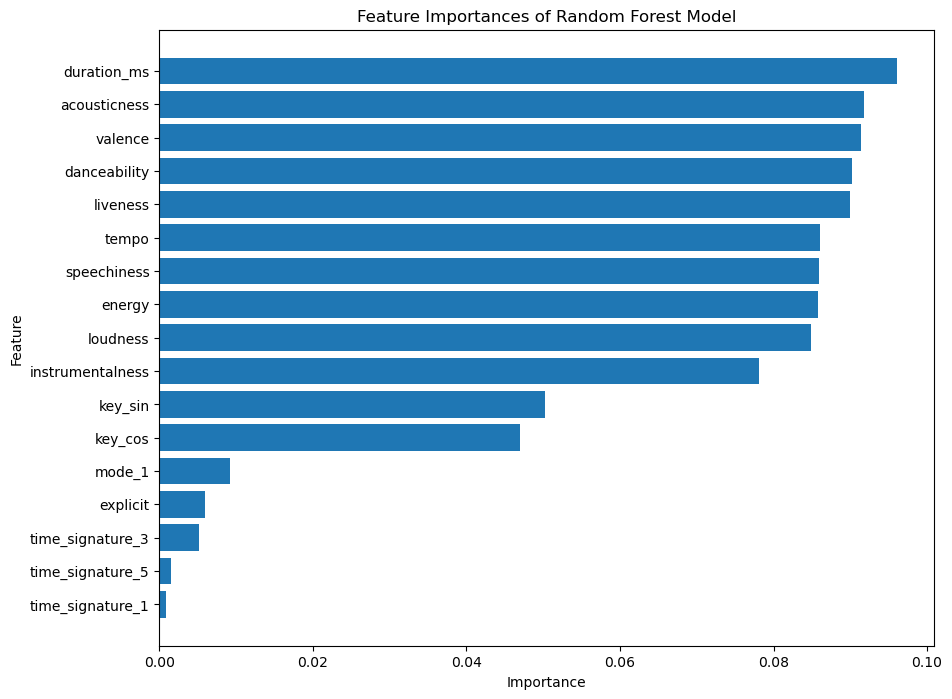

In [29]:
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Model')
plt.gca().invert_yaxis()  #To display the most important feature at the top
plt.show()

### Insights from above:

The feature importances derived from the RandomForestClassifier provide insight into which features have the most influence on the model's predictions. Here's a summary of the top features based on their importance scores:

- **`duration_ms`** (0.096): The duration of the track in milliseconds is the most influential feature, suggesting that longer or shorter tracks have a significant impact on their popularity class.
- **`acousticness`** (0.092): A measure of the acoustic nature of a track, indicating that more acoustic or less acoustic tracks tend to have distinguishable popularity classes.
- **`valence`** (0.091): A measure of the musical positiveness conveyed by a track, showing that the mood of the music is crucial in determining its popularity.
- **`danceability`** (0.090): This feature describes how suitable a track is for dancing based on a combination of musical elements, highlighting the importance of a track's rhythm and beat for its popularity.
- **`liveness`** (0.090): Indicates the presence of an audience in the recording. Tracks that either feel like a live performance or studio recording may influence their popularity differently.

The least important features were related to the time signature and whether the track was explicit, suggesting these factors have minimal impact on the popularity class of a track.

Overall, the model places the greatest importance on the musical properties of a track, such as its duration, acousticness, valence, danceability, and liveness, indicating these are key factors that can predict the popularity of a track.

## Confusion Matrix for Random Forest

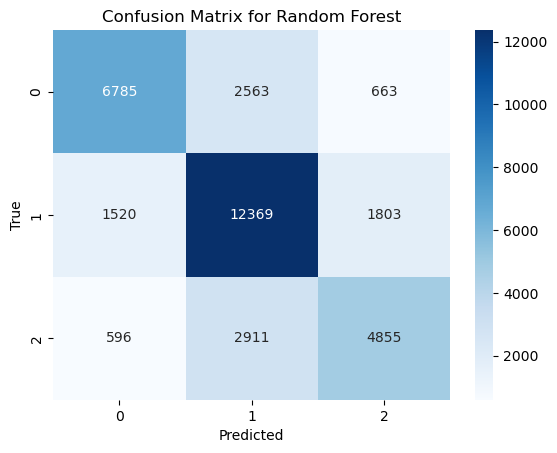

In [36]:
from sklearn.metrics import confusion_matrix

rf_y_pred = rf_best_model.predict(X_test)
cm_rf = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Insights from above:

- The model predicts **medium popularity (class 1)** with high accuracy, with 12,369 true positives.
- The model has difficulty distinguishing between **low popularity (class 0)** and medium popularity, with 2,563 instances of class 0 being misclassified as class 1.
- It performs relatively well at identifying **high popularity (class 2)** tracks, with 4,855 true positives, but there is still a notable number of class 2 tracks being misclassified as class 1 (1,803 instances).

## Plotting ROC Curve for Random Forest:

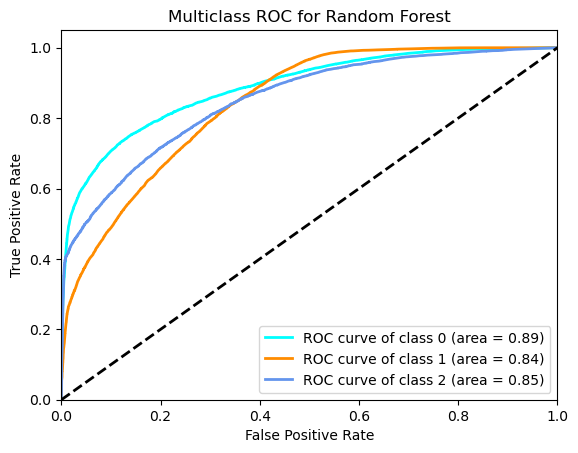

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#Function to plot ROC Curve for Multiclass
def plot_multiclass_roc(model, X_test, y_test, n_classes, model_name):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    y_score = model.predict_proba(X_test)
    
    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    #Plot all ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
n_classes = np.unique(y_test).size

#Plotting Multiclass ROC Curve for Random Forest
plot_multiclass_roc(rf_best_model, X_test, y_test, n_classes, 'Random Forest')

### Insights from above:
- The ROC curves represent the performance of a Random Forest classifier for three classes with varying popularity: low (class 0), medium (class 1), and high (class 2).
- The area under the ROC curve (AUC) for each class measures the classifier's ability to discriminate between that class and the others:
  - **Class 0 (Low popularity)**: AUC of 0.89 indicates good model performance.
  - **Class 1 (Medium popularity)**: AUC of 0.84 suggests moderately good performance.
  - **Class 2 (High popularity)**: AUC of 0.85 shows good performance.
- All classes have AUC values significantly higher than 0.5 (the AUC of a random classifier), which means the model has good class separation ability.
- The closer the ROC curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. Therefore, **Class 0** appears to be the best predicted, while **Class 1** is the least well predicted among the three.

# UNDERSAMPLING MODELLING CONTINUED IN THE NEXT NOTEBOOK

## Saving the Tuned Random Forest Model: 

In [ ]:
import pickle

#Saving the over-sampling random forest model with test accuracy of 70.48%
filename = 'os_random_forest_model_classification.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf_best_model, file)

In [46]:
df.to_pickle('cleaneddata_2.pkl')